# Classical Machine Learning Approach

In this notebook classical machine learning methods are used to predict smoking status based on clinical and biological features. The focus is on comparing basic classifiers and optimizing their performance through data preprocessing, handling class imbalance and hyperparameter tuning.

### Classifiers

Several standard classifiers are trained with default settings to establish baseline performance:

* Logistic Regression – a linear model for binary classification,
* Random Forest – an ensemble of decision trees using bagging,
* Linear SVM – a support vector machine with a linear kernel,
* XGBoost – a gradient boosting decision tree model.

### Experiments

The notebook explores:

1. training baseline classifiers on original, oversampled and undersampled datasets,
2. evaluating models using accuracy, F1-score and ROC AUC,
3. hyperparameter tuning of the best-performing classifier to improve predictive performance.

The ultimate goal is to determine which classical machine learning model and configuration deliver the highest predictive performance for smoking status.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

## Preprocessing

The file `smoking.csv`. is loaded into a DataFrame, allowing the dataset to be accessed and processed

In [2]:
import pandas as pd
df = pd.read_csv('smoking.csv')

### One-hot encoding

Categorical columns `gender`, `oral`, `tartar` are converted into numerical format using one-hot encoding. The first category in each column is dropped to avoid multicollinearity. The resulting encoded columns are then merged back into the original DataFrame, replacing the original categorical columns.

In [3]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df[['gender', 'oral', 'tartar']])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender', 'oral', 'tartar']))

df.drop(['gender', 'oral', 'tartar'], axis=1, inplace=True)
df = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)

print(df.columns)

Index(['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking', 'gender_M', 'tartar_Y'],
      dtype='object')


## Oversampling

Oversampling is applied to balance the target classes. The features and labels are separated, and the `RandomOverSampler` duplicates samples from the minority class to equalize the class distribution.

In [4]:
from imblearn.over_sampling import RandomOverSampler

X = df.drop('smoking', axis=1)
y = df['smoking']

over_sampler = RandomOverSampler(random_state=42)

## Undersampling

This method involves removing data from the majority class. Random records are removed from the majority sample until both classes have the same cardinality.

In [5]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)

## Scaling and partitioning into sets

A standard scaler and train–test split configuration are prepared. The scaler will normalize numerical features, while the constants define the test set size and the random seed used for reproducible data splitting.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
TEST_SIZE = 0.2
RANDOM_STATE = 42

The dataset is prepared for model training by separating features and labels, removing the `ID` column and scaling numerical features. Each dataset variant: original, oversampled, and undersampled is split into training and testing sets with stratification to preserve the class distribution.

In [7]:
X_orig = df.drop(['smoking', 'ID'], axis=1)
y_orig = df['smoking']

X_orig_train, X_orig_test, y_orig_train, y_orig_test = train_test_split(
    X_orig, y_orig, test_size=TEST_SIZE, stratify=y_orig, random_state=RANDOM_STATE
)

# Oversampling
X_over_train, y_over_train = over_sampler.fit_resample(X_orig_train, y_orig_train)

# Undersampling
X_under_train, y_under_train = under_sampler.fit_resample(X_orig_train, y_orig_train)

In [8]:
X_orig_train_scaled = scaler.fit_transform(X_orig_train)
X_orig_test_scaled = scaler.transform(X_orig_test)

X_over_train_scaled = scaler.fit_transform(X_over_train)
X_over_test_scaled = scaler.transform(X_orig_test)

X_under_train_scaled = scaler.fit_transform(X_under_train)
X_under_test_scaled = scaler.transform(X_orig_test)

A helper function is defined to return the training and testing sets for a specified dataset type.

In [9]:
def get_dataset(kind='orig'):
    """Returns (X_train, X_test, y_train, y_test) for the given data type"""
    if kind == 'over':
        return X_over_train_scaled, X_over_test_scaled, y_over_train, y_orig_test
    elif kind == 'under':
        return X_under_train_scaled, X_under_test_scaled, y_under_train, y_orig_test
    else:
        return X_orig_train_scaled, X_orig_test_scaled, y_orig_train, y_orig_test

# Model training  

Required machine learning models, metrics and utilities for hyperparameter tuning are imported. An attempt is made to import XGBoost, with a flag set to indicate whether it is available for use.

In [10]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

A function is defined to evaluate a trained model on test data. It calculates three metrics: accuracy, F1-score and ROC AUC using predicted labels and probabilities.

In [11]:
def evaluate(model, X_test, y_test):
    pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        proba = model.decision_function(X_test)

    return {
        "accuracy": accuracy_score(y_test, pred),
        "f1": f1_score(y_test, pred),
        "roc_auc": roc_auc_score(y_test, proba)
    }

## Training

A function is defined to train several basic classifiers with their default settings. The models included are:

* Logistic Regression – a linear model for binary classification,
* Random Forest – an ensemble of decision trees using bagging,
* Linear SVM – a support vector machine with a linear kernel,
* XGBoost – a gradient boosting tree-based model.

For a given dataset type `orig`, `over` or `under` the function performs the following steps:

1. Retrieves the corresponding training and testing sets,
2. Trains each classifier on the training data,
3. Evaluates performance on the test set using accuracy, F1-score and ROC AUC.

In [12]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from tqdm import tqdm

def train_all_models(kind="orig"):
    X_train, X_test, y_train, y_test = get_dataset(kind)
    
    selector = SelectKBest(mutual_info_classif, k=20)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    results = {}
    total_models = 4 + int(XGB_AVAILABLE)
    pbar = tqdm(total=total_models, ncols=100, desc=f"Training models ({kind})")

    # Logistic Regression
    log_reg_pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('clf', LogisticRegression(max_iter=2000))
    ])
    log_reg_pipeline.fit(X_train, y_train)
    results["Logistic Regression"] = evaluate(log_reg_pipeline, X_test, y_test)
    pbar.update(1)

    # Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    results["Random Forest"] = evaluate(rf, X_test, y_test)
    pbar.update(1)

    # SVM
    svm_pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('clf', LinearSVC())
    ])
    svm_pipeline.fit(X_train, y_train)
    results["SVM"] = evaluate(svm_pipeline, X_test, y_test)
    pbar.update(1)

    # XGBoost
    if XGB_AVAILABLE:
        xgb = XGBClassifier()
        xgb.fit(X_train, y_train)
        results["XGBoost"] = evaluate(xgb, X_test, y_test)
        pbar.update(1)

    pbar.close()
    return pd.DataFrame(results).T

The previously defined function is used to train all basic classifiers on three dataset variants: original, oversampled and undersampled.

In [13]:
results_orig = train_all_models("orig")
results_orig["dataset"] = "orig"

results_over = train_all_models("over")
results_over["dataset"] = "over"

results_under = train_all_models("under")
results_under["dataset"] = "under"


print("ORIGINAL")
display(results_orig)

print("OVERSAMPLED")
display(results_over)

print("UNDERSAMPLED")
display(results_under)

Training models (under):  80%|████████████████████████████████        | 4/5 [00:12<00:03,  3.09s/it]

ORIGINAL


,accuracy,f1,roc_auc,dataset
Logistic Regression,0.746835,0.671635,0.828332,orig
Random Forest,0.832660,0.775476,0.916089,orig
SVM,0.746387,0.677475,0.828201,orig
XGBoost,0.778885,0.707169,0.860966,orig


OVERSAMPLED


,accuracy,f1,roc_auc,dataset
Logistic Regression,0.716671,0.703551,0.825121,over
Random Forest,0.832211,0.784404,0.915806,over
SVM,0.708502,0.702737,0.825135,over
XGBoost,0.768292,0.725979,0.859101,over


UNDERSAMPLED


,accuracy,f1,roc_auc,dataset
Logistic Regression,0.717210,0.703278,0.828115,under
Random Forest,0.793159,0.762474,0.900158,under
SVM,0.708412,0.702782,0.828130,under
XGBoost,0.760930,0.723669,0.857027,under


The model performances vary across three dataset variants:

* in original dataset Random Forest achieves the highest accuracy, F1-score and ROC AUC. XGBoost performs better than Logistic Regression and SVM which perform similarly with lower scores,
* in oversampled dataset F1-scores improve for all models compared to the original dataset, with Random Forest showing the best overall performance,
* in undersampled dataset performance is slightly lower than oversampling but higher than the original for most models. Random Forest still leads, XGBoost is next, while Logistic Regression and SVM show similar F1-scores.

The results will be displayed in a single table.

In [14]:
results_all = pd.concat([results_orig, results_over, results_under])
display(results_all)

,accuracy,f1,roc_auc,dataset
Logistic Regression,0.746835,0.671635,0.828332,orig
Random Forest,0.832660,0.775476,0.916089,orig
SVM,0.746387,0.677475,0.828201,orig
XGBoost,0.778885,0.707169,0.860966,orig
Logistic Regression,0.716671,0.703551,0.825121,over
Random Forest,0.832211,0.784404,0.915806,over
SVM,0.708502,0.702737,0.825135,over
XGBoost,0.768292,0.725979,0.859101,over
Logistic Regression,0.717210,0.703278,0.828115,under
Random Forest,0.793159,0.762474,0.900158,under


The best model is Random Forest trained on the oversampled dataset. It achieves the highest F1-score and ROC AUC in combination with oversampling.

### Visualizations

The results from all datasets are prepared for visualization.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = results_all.reset_index().rename(columns={"index": "model"})

Bar plots are created to compare the performance of all models across the three datasets. Each subplot shows a different metric—accuracy, F1-score and ROC AUC.

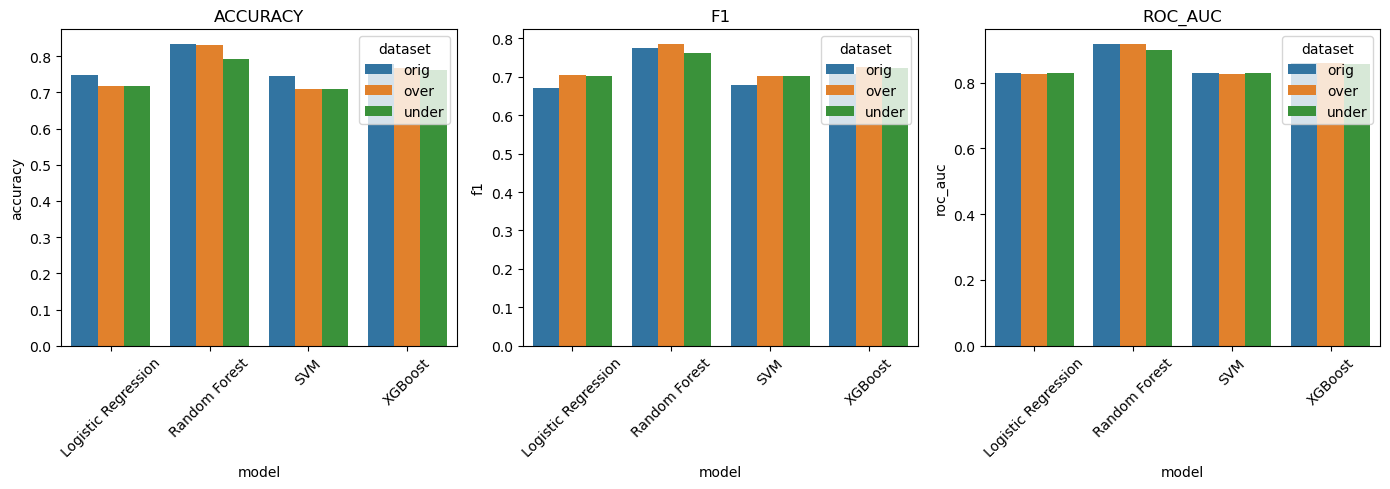

In [16]:
metrics = ["accuracy", "f1", "roc_auc"]

plt.figure(figsize=(14, 5))
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=df_plot, x="model", y=metric, hue="dataset")
    plt.title(metric.upper())
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Random Forest with oversampled data shows the best performance in all three metrics.

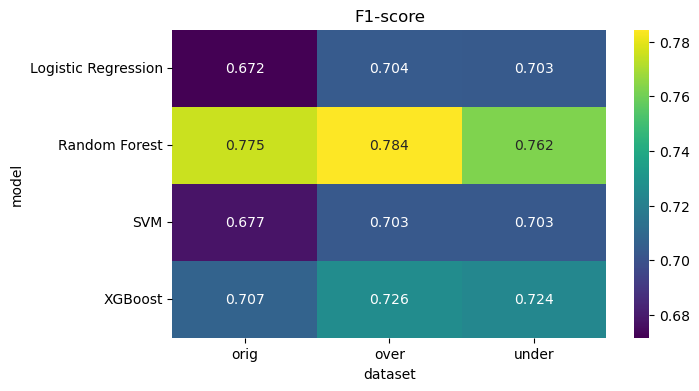

In [17]:
pivot_f1 = df_plot.pivot(index="model", columns="dataset", values="f1")

plt.figure(figsize=(7, 4))
sns.heatmap(pivot_f1, annot=True, cmap="viridis", fmt=".3f")
plt.title("F1-score")
plt.show()

The same observation is confirmed on the heatmap.

The best-performing model is identified by sorting all results by F1-score. The model name, dataset type and corresponding F1-score are  displayed below.

In [18]:
best_row = results_all.sort_values(by="f1", ascending=False).iloc[0]

best_model_name = best_row.name
best_dataset = best_row["dataset"]
best_f1 = best_row["f1"]

print(f"Model: {best_model_name}")
print(f"Metoda: {best_dataset}")
print(f"F1-score: {best_f1:.4f}")

Model: Random Forest
Metoda: over
F1-score: 0.7844


## Experiments

The Random Forest on oversampled data is selected as the base model due to the highest F1-score across all the trained models.

Hyperparameters will be tuned using Optuna to further improve performance.

In [19]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

X_train, X_test, y_train, y_test = get_dataset("over")

This cell defines the objective function used by Optuna to tune the Random Forest hyperparameters: 
1. A set of hyperparameters is suggested by Optuna for the trial, including number of trees, maximum depth, minimum samples for split and leaf, max features and the splitting criterion.  
2. A Random Forest model is then created using these parameters.  
3. The model is evaluated using 5-fold stratified cross-validation on the training data, calculating the F1-score for each fold.  
4. The mean F1-score across folds is returned, which Optuna uses to decide which hyperparameters perform best.  

This setup allows automated search for hyperparameters that maximize performance of the model.

In [20]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 4, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(f1_score)).mean()
    
    return f1

The function is optimized over 50 trials to find the best Random Forest hyperparameters. The best trial’s F1-score and parameters are displayed.

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("F1-score: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

[I 2025-12-06 13:18:02,324] A new study created in memory with name: no-name-f97e75c6-3328-43ad-a8b7-dd9dc69a26f4
[I 2025-12-06 13:19:03,160] Trial 0 finished with value: 0.8321527165139779 and parameters: {'n_estimators': 606, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.8321527165139779.
[I 2025-12-06 13:20:18,004] Trial 1 finished with value: 0.8588503013290254 and parameters: {'n_estimators': 592, 'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.8588503013290254.
[I 2025-12-06 13:20:53,160] Trial 2 finished with value: 0.856932278227873 and parameters: {'n_estimators': 285, 'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.8588503013290254.
[I 2025-12-06 13:21:42,459] Trial 3 finished with value: 0.8409

[I 2025-12-06 13:44:42,925] Trial 30 finished with value: 0.8760218769016127 and parameters: {'n_estimators': 628, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 17 with value: 0.8784426076002649.
[I 2025-12-06 13:46:12,839] Trial 31 finished with value: 0.8741173083451901 and parameters: {'n_estimators': 634, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 17 with value: 0.8784426076002649.
[I 2025-12-06 13:47:40,954] Trial 32 finished with value: 0.8733893689875926 and parameters: {'n_estimators': 585, 'max_depth': 24, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 17 with value: 0.8784426076002649.
[I 2025-12-06 13:49:16,936] Trial 33 finished with value: 0.8742926013304209 and parameters: {'n_estimators': 633, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_

Best trial:
F1-score:  0.8811696095132693
Params: 
n_estimators: 465
max_depth: 35
min_samples_split: 3
min_samples_leaf: 1
max_features: log2
criterion: entropy


The highest F1-score of 0.881 was achieved using:
- 465 trees,
- maximum depth of 35,
- minimum 3 samples to split a node,
- minimum 1 sample per leaf,
- `log2` features considered at each split,
- `entropy` as the splitting criterion.

The best hyperparameters from the Optuna study are used to create a new Random Forest model. The model is trained on the training data and then evaluated on the test set. Performance is measured using a classification report.

In [22]:
best_params = trial.params
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

from sklearn.metrics import classification_report, roc_auc_score
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      7048
           1       0.74      0.85      0.79      4091

    accuracy                           0.83     11139
   macro avg       0.82      0.84      0.83     11139
weighted avg       0.84      0.83      0.84     11139

ROC AUC: 0.9190713689777761


The optimized Random Forest achieves acceptable results on the test set:
- class 0: precision 0.91, recall 0.82, F1-score 0.86,
- class 1: precision 0.74, recall 0.85, F1-score 0.79,
- overall accuracy: 0.83,
- weighted F1-score: 0.84,
- ROC AUC: 0.919.

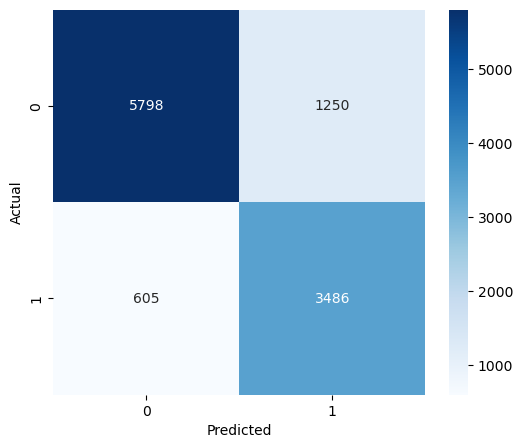

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The heatmap shows the number of correct and incorrect predictions for each class:
- class 0 predicted correctly 5798 cases,
- class 0 predicted as 1 in 1250 cases,
- class 1 predicted as 0 in 605 cases,
- class 1 predicted correctly 3486 cases.

# Conclusions

Based on the results of this notebook, the following conclusions can be drawn:
- Random Forest outperformed other models, with oversampling further improving F1-score and ROC AUC,
- hyperparameter tuning with Optuna increased the F1-score from 0.784 to 0.881 on the oversampled training set,
- confusion matrix analysis shows slightly higher misclassification of non-smokers as smokers, but overall predictions are reliable.